# Artificial Neural Networks for Regression

_By: Ling Li Ya, Liana_

## Pre-training Preparation

### Installing Dependencies

In [1]:
!pip install tensorflow
!pip install keras

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

2021-12-02 13:16:43.912527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 13:16:43.912635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Loading Data

In [15]:
# Cleaned dataset with no outliers
X_train_no = pd.read_csv('../dataset/no_outliers/X_train.csv')
X_test_no = pd.read_csv('../dataset/no_outliers/X_test.csv')
y_train_no = pd.read_csv('../dataset/no_outliers/y_train.csv')
y_test_no = pd.read_csv('../dataset/no_outliers/y_test.csv')

# Uncleaned original data
X_train_with = pd.read_csv('../dataset/with_outliers/X_train.csv')
X_test_with = pd.read_csv('../dataset/with_outliers/X_test.csv')
y_train_with = pd.read_csv('../dataset/with_outliers/y_train.csv')
y_test_with = pd.read_csv('../dataset/with_outliers/y_test.csv')

In [16]:
# def standardise_data(X_train, y_train, X_test, y_test):
    # X_scaler = StandardScaler()
    # y_scaler = StandardScaler()

    # # Scale data to standardise data values
    # X_train_trans = X_scaler.fit_transform(X_train)
    # y_train_trans = y_scaler.fit_transform(y_train)
    # X_test_trans = X_scaler.transform(X_test)
    # y_test_trans = y_scaler.transform(y_test)
    
    # print(X_train_trans.shape, y_train_trans.shape, X_test_trans.shape, y_test_trans.shape)

    # return X_scaler, y_scaler, X_train_trans, y_train_trans, X_test_trans, y_test_trans
    # return X_scaler, y_scaler, X_train, y_train, X_test, y_test

# X_scaler_no, y_scaler_no, X_train_no_trans, y_train_no_trans, X_test_no_trans, y_test_no_trans = standardise_data(X_train_no, y_train_no, X_test_no, y_test_no)
X_train_no_trans, y_train_no_trans, X_test_no_trans, y_test_no_trans = X_train_no, y_train_no, X_test_no, y_test_no

## Training

Using a layer with 5 neurons, with 9 input dimensions of normal weight, using relu activation function. Batch size is 20 and training epochs are 50.

In [17]:
def create_seq_model():
    model = Sequential()

    # Defining the input layer and first hidden layer
    model.add(Dense(units=5, input_dim=9, kernel_initializer='normal', activation='relu'))

    # Defining the second layer of the model
    model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

    # The output neuron is a single fully connected node as only a single number is predicted
    model.add(Dense(1, kernel_initializer='normal'))

    # Compiling the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

    return model

def train_model(model, X_train, y_train):
    # Fitting the ANN to the training data
    model.fit(X_train, y_train, batch_size=20, epochs=50, verbose=1)

    return model

model_no = create_seq_model()
model_no = train_model(model_no, X_train_no_trans, y_train_no_trans)

Epoch 1/50
29/29 [==============================] - 0s 908us/step - loss: 0.3062 - mse: 0.3062 - mae: 0.5059
Epoch 2/50
29/29 [==============================] - 0s 860us/step - loss: 0.2504 - mse: 0.2504 - mae: 0.4478
Epoch 3/50
29/29 [==============================] - 0s 879us/step - loss: 0.1528 - mse: 0.1528 - mae: 0.3321
Epoch 4/50
29/29 [==============================] - 0s 895us/step - loss: 0.0585 - mse: 0.0585 - mae: 0.1976
Epoch 5/50
29/29 [==============================] - 0s 885us/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1588
Epoch 6/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0351 - mse: 0.0351 - mae: 0.1511
Epoch 7/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0311 - mse: 0.0311 - mae: 0.1422
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0266 - mse: 0.0266 - mae: 0.1315
Epoch 9/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1204
Epoch 10/50
29/29 [========

## Hyperparameter Tuning

To find the best accuracy with the minimum number of layers/neurons.

### Grid Search

Mean Square Error (MSE) is used with the formula `(sum of all (y_true - y_pred)^2)/total number of y_true`

In [18]:
# Find the best parameters for ANN
def find_best_params(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]

    results = pd.DataFrame(columns=['trial_num', 'param', 'accuracy'])
    
    # Initialising the trials
    trial_number = 0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            trial_number += 1
            # Create ANN model
            model = Sequential()

            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # Output neuron
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            pred = model.predict(X_test)

            MSE = 0
            for i in range(y_test.shape[0]):
                MSE += (y_test[i,0] - pred[i][0])**2

            MSE /= y_test.shape[0]
            
            # Printing the results of the current iteration
            print(trial_number, 'Parameters:','batch_size:', batch_size_trial,'-', 'Epochs:',epochs_trial, 'MSE:', MSE)
            
            results = results.append(pd.DataFrame(data=[[trial_number, str(batch_size_trial)+'-'+str(epochs_trial), MSE]], columns=['trial_num', 'param', 'mse'] ))

    return(results)

results_no = find_best_params(X_train_no_trans, y_train_no_trans, X_test_no_trans, y_test_no_trans)

KeyError: (0, 0)

### Plotting Results

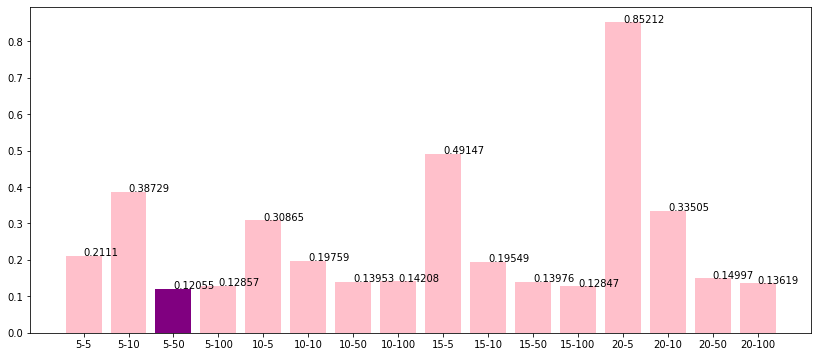

In [ ]:
def plot_bar_chart(results):
    plt.figure(figsize=(14,6))
    colors = ['pink' if result != min(results['mse']) else 'purple' for result in results['mse']]
    plt.bar(results['param'], height=results['mse'], color=colors)
    # plt.axhline(y=1.0, color='purple', linestyle='-')
    for a, b in zip([x for x in range(len(results['mse']))], round(results['mse'], 5)):
        plt.text(a, b, str(b), color='black')
    plt.show()

plot_bar_chart(results_no)

For MSE, a lower value is better. From the graph above, it can be known that the best hyperparameters are `batch_size` = 10 and `epochs` = 100.

In [ ]:
def evaluate_model(test_data):
    # Sum of squared error
    test_data['SE'] = (test_data['count'] - test_data['pred_count'])**2
    r2 = r2_score(test_data['count'], test_data['pred_count'])

    print(test_data.head())

    print("r2: ", r2)
    print("MSE: ", np.mean(test_data['SE']))

In [ ]:
# Fine-tune hyperparameters
# def fine_tune_model(model, batch_size, epochs, X_scaler, y_scaler, X_train_trans, y_train_trans, X_test_trans, y_test_trans, columns):
def fine_tune_model(model, batch_size, epochs, X_train_trans, y_train_trans, X_test_trans, y_test_trans, columns):
    model.fit(X_train_trans, y_train_trans, batch_size=batch_size, epochs=epochs, verbose=0)

    pred = model.predict(X_test_trans)

    test_data_scaled = pd.DataFrame(data=X_test_trans, columns=columns)
    test_data_scaled['count'] = y_test_trans
    test_data_scaled['pred_count'] = pred
    evaluate_model(test_data_scaled)

    # # Scale predictions
    # pred = y_scaler.inverse_transform(pred)

    # # Scale back to original
    # y_test = y_scaler.inverse_transform(y_test_trans)
    # X_test = X_scaler.inverse_transform(X_test_trans)

    # test_data = pd.DataFrame(data=X_test, columns=columns)
    # test_data['count'] = y_test
    # test_data['pred_count'] = pred
    # print(test_data.head())

    # return test_data
    return test_data_scaled

test_data_no = fine_tune_model(
        model=model_no,
        batch_size=10,
        epochs=100,
        # X_scaler=X_scaler_no,
        # y_scaler=y_scaler_no,
        X_train_trans=X_train_no_trans,
        y_train_trans=y_train_no_trans,
        X_test_trans=X_test_no_trans,
        y_test_trans=y_test_no_trans,
        columns=X_test_no.columns
    )

     season      year     month  holiday   weekday   weather  temperature  \
0  0.449189  1.003466  0.147272 -0.16873 -1.505757 -0.736674     1.234309   
1 -0.461798  1.003466 -0.439786 -0.16873  0.493847 -0.736674     0.533490   
2  0.449189  1.003466  0.440802 -0.16873  0.993748  1.090784     1.475494   
3 -0.461798  1.003466 -0.733315 -0.16873  0.993748 -0.736674    -0.504081   
4  1.360175  1.003466  1.321389 -0.16873 -1.005856 -0.736674    -0.963703   

   humidity  windspeed     count  pred_count        SE  
0 -0.028125  -0.246866  1.095397    1.053750  0.001734  
1 -0.761407   0.529099  1.506397    1.598219  0.008431  
2  0.104396   0.349382  1.397250    0.881825  0.265662  
3 -1.771513   1.460496  1.023851    0.651902  0.138346  
4 -0.943989   0.619070  0.396644    0.270238  0.015979  
r2:  0.8994398198769683
MSE:  0.11479993171537962


In [ ]:
model_no.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 50        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


## Using Data With Outliers

In [ ]:
X_scaler_with, y_scaler_with, X_train_with_trans, y_train_with_trans, X_test_with_trans, y_test_with_trans = standardise_data(X_train_with, y_train_with, X_test_with, y_test_with)

(584, 9) (584, 1) (147, 9) (147, 1)


In [ ]:
model_with = create_seq_model()
model_with = train_model(model_with, X_train_with_trans, y_train_with_trans)

Epoch 1/50
30/30 [==============================] - 0s 2ms/step - loss: 0.9991 - mse: 0.9991 - mae: 0.8156
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.9879 - mse: 0.9879 - mae: 0.8109
Epoch 3/50
30/30 [==============================] - 0s 2ms/step - loss: 0.9386 - mse: 0.9386 - mae: 0.7895
Epoch 4/50
30/30 [==============================] - 0s 2ms/step - loss: 0.8123 - mse: 0.8123 - mae: 0.7316
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6134 - mse: 0.6134 - mae: 0.6378
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 0.4300 - mse: 0.4300 - mae: 0.5299
Epoch 7/50
30/30 [==============================] - 0s 1ms/step - loss: 0.3059 - mse: 0.3059 - mae: 0.4382
Epoch 8/50
30/30 [==============================] - 0s 1ms/step - loss: 0.2423 - mse: 0.2423 - mae: 0.3791
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2160 - mse: 0.2160 - mae: 0.3516
Epoch 10/50
30/30 [==================

The same `batch_size` and `epochs` are used for accuracy comparison.

In [ ]:
test_data_with = fine_tune_model(
    model=model_with,
    batch_size=10,
    epochs=100,
    X_scaler=X_scaler_with,
    y_scaler=y_scaler_with,
    X_train_trans=X_train_with_trans,
    y_train_trans=y_train_with_trans,
    X_test_trans=X_test_with_trans,
    y_test_trans=y_test_with_trans,
    columns=X_test_with.columns,
)

     season      year     month   holiday   weekday   weather  temperature  \
0  0.441688 -0.993174  0.131722 -0.167836  1.508537 -0.720359     1.060122   
1  0.441688 -0.993174  0.131722 -0.167836  0.502271 -0.720359     1.404064   
2 -1.362130 -0.993174 -1.603446 -0.167836  1.508537  1.141100    -1.401794   
3 -1.362130 -0.993174 -1.314251 -0.167836 -0.503995  1.141100    -1.625316   
4 -1.362130  1.006873 -1.603446 -0.167836  0.502271  1.141100    -0.813466   

   humidity  windspeed     count  pred_count        SE  
0 -0.276179   0.246691  0.750388    0.339964  0.168448  
1  0.196746  -0.396460  0.050831    0.068289  0.000305  
2 -0.891873  -0.412649 -1.706735   -1.463633  0.059098  
3  1.469644  -1.783575 -1.647869   -1.832364  0.034038  
4  1.041464  -1.519431 -0.220898   -0.313726  0.008617  
r2:  0.8866752303950303
MSE:  0.13314511075402408


In [ ]:
model_with.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 5)                 50        
                                                                 
 dense_52 (Dense)            (None, 5)                 30        
                                                                 
 dense_53 (Dense)            (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In conclusion, using cleaned data without outliers would give a higher accuracy than using data with outliers.